In [1]:
from bayesian_regression.util.generators import random_poisson_model
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import pandas as pd
from skbio import TreeNode
from biom import load_table, Table
from sklearn.utils import check_random_state
from scipy.sparse import coo_matrix
from skbio.stats.composition import _gram_schmidt_basis, closure
import os
import edward as ed
import tensorflow as tf
from tqdm import trange, tqdm
import sys
from gneiss.cluster import rank_linkage
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
NUMERATOR=1
DENOMINATOR=0
def sparse_balance_basis(tree):
    """ Calculates sparse representation of an ilr basis from a tree.

    This computes an orthonormal basis specified from a bifurcating tree.

    Parameters
    ----------
    tree : skbio.TreeNode
        Input bifurcating tree.  Must be strictly bifurcating
        (i.e. every internal node needs to have exactly 2 children).
        This is used to specify the ilr basis.

    Returns
    -------
    scipy.sparse.coo_matrix
       The ilr basis required to perform the ilr_inv transform.
       This is also known as the sequential binary partition.
       Note that this matrix is represented in clr coordinates.
    nodes : list, str
        List of tree nodes indicating the ordering in the basis.

    Raises
    ------
    ValueError
        The tree doesn't contain two branches.

    """
    # this is inspired by @wasade in
    # https://github.com/biocore/gneiss/pull/8
    t = tree.copy()
    D = len(list(tree.tips()))
    # calculate number of tips under each node
    for n in t.postorder(include_self=True):
        if n.is_tip():
            n._tip_count = 1
        else:
            try:
                left, right = n.children[NUMERATOR], n.children[DENOMINATOR],
            except:
                raise ValueError("Not a strictly bifurcating tree.")
            n._tip_count = left._tip_count + right._tip_count

    # calculate k, r, s, t coordinate for each node
    left, right = t.children[NUMERATOR], t.children[DENOMINATOR],
    t._k, t._r, t._s, t._t = 0, left._tip_count, right._tip_count, 0
    for n in t.preorder(include_self=False):
        if n.is_tip():
            n._k, n._r, n._s, n._t = 0, 0, 0, 0

        elif n == n.parent.children[NUMERATOR]:
            n._k = n.parent._k
            n._r = n.children[NUMERATOR]._tip_count
            n._s = n.children[DENOMINATOR]._tip_count
            n._t = n.parent._s + n.parent._t
        elif n == n.parent.children[DENOMINATOR]:
            n._k = n.parent._r + n.parent._k
            n._r = n.children[NUMERATOR]._tip_count
            n._s = n.children[DENOMINATOR]._tip_count
            n._t = n.parent._t
        else:
            raise ValueError("Tree topology is not correct.")

    # navigate through tree to build the basis in a sparse matrix form
    value = []
    row, col = [], []
    nodes = []
    i = 0

    for n in t.levelorder(include_self=True):

        if n.is_tip():
            continue

        for j in range(n._k, n._k + n._r):
            row.append(i)
            col.append(D-1-j)
            A = np.sqrt(n._s / (n._r * (n._s + n._r)))

            value.append(A)

        for j in range(n._k + n._r, n._k + n._r + n._s):
            row.append(i)
            col.append(D-1-j)
            B = -np.sqrt(n._r / (n._s * (n._s + n._r)))

            value.append(B)
        i += 1
        nodes.append(n.name)

    basis = coo_matrix((value, (row, col)), shape=(D-1, D), dtype=np.float32)

    return basis, nodes


def match_tips(table, tree):
    """ Returns the contingency table and tree with matched tips.

    Sorts the columns of the contingency table to match the tips in
    the tree.  The ordering of the tips is in post-traversal order.
    If the tree is multi-furcating, then the tree is reduced to a
    bifurcating tree by randomly inserting internal nodes.
    The intersection of samples in the contingency table and the
    tree will returned.

    Parameters
    ----------
    table : biom.Table
        Contingency table where samples correspond to rows and
        features correspond to columns.
    tree : skbio.TreeNode
        Tree object where the leafs correspond to the features.

    Returns
    -------
    biom.Table :
        Subset of the original contingency table with the common features.
    skbio.TreeNode :
        Sub-tree with the common features.
    """

    tips = [x.name for x in tree.tips()]
    common_tips = set(tips) & set(table.ids(axis='observation'))
    _tree = tree.shear(names=list(common_tips))

    def filter_uncommon(val, id_, md):
        return id_ in common_tips
    _table = table.filter(filter_uncommon, 
                          axis='observation', inplace=False)

    _tree.bifurcate()
    _tree.prune()
    sort_f = lambda x: [n.name for n in _tree.tips()]
    _table = _table.sort(sort_f=sort_f, axis='observation')
    return _table, _tree


def random_poisson_model(num_samples, num_features,
                         tree=None,
                         reps=1,
                         low=2, high=10,
                         alpha_mean=0,
                         alpha_scale=5,
                         theta_mean=0,
                         theta_scale=5,
                         gamma_mean=0,
                         gamma_scale=5,
                         kappa_mean=0,
                         kappa_scale=5,
                         beta_mean=0,
                         beta_scale=5,
                         seed=0):
    """ Generates a table using a random poisson regression model.

    Here we will be simulating microbial counts given the model, and the
    corresponding model priors.

    Parameters
    ----------
    num_samples : int
        Number of samples
    num_features : int
        Number of features
    tree : np.array
        Tree specifying orthonormal contrast matrix.
    low : float
        Smallest gradient value.
    high : float
        Largest gradient value.
    alpha_mean : float
        Mean of alpha prior  (for global bias)
    alpha_scale: float
        Scale of alpha prior  (for global bias)
    theta_mean : float
        Mean of theta prior (for sample bias)
    theta_scale : float
        Scale of theta prior (for sample bias)
    gamma_mean : float
        Mean of gamma prior (for feature bias)
    gamma_scale : float
        Scale of gamma prior (for feature bias)
    kappa_mean : float
        Mean of kappa prior (for overdispersion)
    kappa_scale : float
        Scale of kappa prior (for overdispersion)
    beta_mean : float
        Mean of beta prior (for regression coefficients)
    beta_scale : float
        Scale of beta prior (for regression coefficients)

    Returns
    -------
    table : biom.Table
        Biom representation of the count table.
    metadata : pd.DataFrame
        DataFrame containing relevant metadata.
    beta : np.array
        Regression parameter estimates.
    theta : np.array
        Bias per sample.
    gamma : np.array
        Bias per feature
    kappa : np.array
        Dispersion rates of counts per sample.
    """
    # generate all of the coefficient using the random poisson model
    state = check_random_state(seed)
    alpha = state.normal(alpha_mean, alpha_scale)
    theta = state.normal(theta_mean, theta_scale, 
                         size=(num_samples, 1)) + alpha
    beta = state.normal(beta_mean, beta_scale, size=num_features-1)
    gamma = state.normal(gamma_mean, gamma_scale, size=num_features-1)
    kappa = state.lognormal(kappa_mean, kappa_scale, size=num_features-1)

    if tree is None:
        basis = coo_matrix(_gram_schmidt_basis(num_features), 
                           dtype=np.float32)
    else:
        basis = sparse_balance_basis(tree)[0]

    G = np.hstack([np.linspace(low, high, num_samples // reps)] 
                  for _ in range(reps))
    N, D = num_samples, num_features
    G_data = np.vstack((np.ones(N), G)).T
    B = np.vstack((gamma, beta))

    mu = G_data @ B @ basis
    # we use kappa here to handle overdispersion.
    #eps = lambda x: state.normal([0] * len(x), x)    
    eps_ = np.vstack([state.normal([0] * len(kappa), kappa)
                      for _ in range(mu.shape[0])])
    eps = eps_ @ basis
    table = np.vstack(
        state.poisson(
            np.exp(
                mu[i, :] + theta[i] #+ eps[i, :]                
            )
        )
        for i in range(mu.shape[0])        
    ).T

    samp_ids = ['S%d' % i for i in range(num_samples)]
    feat_ids = ['F%d' % i for i in range(num_features)]
    balance_ids = ['L%d' % i for i in range(num_features-1)]

    table = Table(table, feat_ids, samp_ids)
    metadata = pd.DataFrame({'G': G.ravel()}, index=samp_ids)
    beta = pd.DataFrame({'beta': beta.ravel()}, index=balance_ids)
    gamma = pd.DataFrame({'gamma': gamma.ravel()}, index=balance_ids)
    kappa = pd.DataFrame({'kappa': kappa.ravel()}, index=balance_ids)
    theta = pd.DataFrame({'theta': theta.ravel()}, index=samp_ids)
    return table, metadata, basis, alpha, beta, theta, gamma, kappa, eps_

# Simulation

We will first propose a generative model model species distributions.

The model will be constructed as follows

Generate a linear regression given known regression coefficients and intercepts (B) and known environmental gradients (G)

$v = GB$

$v$ represents the log ratios (also known as logits) of the species.  These logits can ultimately be used to interpret trends of ecological succession amongst groups of species.  However, these log ratios cannot be directly estimated (since it isn't possible to take the logarithm of zero).  Instead, we will rely on the generative process, and convert these log ratios to proportions, before generating counts.

$v$ can be converted to proportions using the ILR transform.  $v$ has $D-1$ dimensions, where $D$ is the number of species.  The ILR transform can be represented as follows

$\eta = \Psi v$

where $\Psi$ is an orthonormal basis of dimensions $D \times D-1$.  It is possible to encode a tree topology into $\Psi$.  One approach is to take phylogenetic trees in order to infer evolutionary trends with respect to environmental gradients.  For the sake of simplicity, we will choose an arbituary tree.  In terms of generating microbial counts, the choice tree doesn't matter since all trees will generate orthonormal bases that are equivalent up to rotation.

Once we have proportions estimated by $\eta$, we can then use these proportions to parameterize a counting distribution, such as the Multinomial distribution, the Poisson distribution or the Negative Binomial distribution.

Here we will use the Poisson distribution to simulate microbial counts.  In order to account or differences due to sequencing depth and additional sample biases, a bias constant $\theta$ is added to the model.  A global bias $\alpha$ is added to everything.

$Y \sim Poisson( exp(\eta + \theta + \alpha) )$

To evaluate how well the model fits, we will first simulate the data given the model.  We will randomly simulate the coefficients from a given prior distribution, and then generate the counts from the model.
If the model works, we should be able to recover the underlying parameters, and regenerate the microbial count table.

In [3]:
dirname = '../../data/poisson_s100_f100'
num_samples, num_features = 100, 100
table = load_table(os.path.join(dirname, 'table.biom'))
metadata = pd.read_table(os.path.join(dirname, 'metadata.txt'), index_col=0)
tree = TreeNode.read(os.path.join(dirname, 'tree.nwk'))
sim_beta = pd.read_csv(os.path.join(dirname, 'beta.csv'), index_col=0)
sim_gamma = pd.read_csv(os.path.join(dirname, 'gamma.csv'), index_col=0)
sim_theta = pd.read_csv(os.path.join(dirname, 'theta.csv'), index_col=0)
basis, _ = sparse_balance_basis(tree)

"""
res = random_poisson_model(num_samples, num_features,
                           reps=1,
                           low=-.1, high=.1,
                           alpha_mean=-1,
                           alpha_scale=0.1,
                           theta_mean=0,
                           theta_scale=1,
                           gamma_mean=0,
                           gamma_scale=1,
                           kappa_mean=0,
                           kappa_scale=0.5,
                           beta_mean=0,
                           beta_scale=3 
                          ) 
table, metadata, basis, sim_alpha, sim_beta, sim_theta, sim_gamma, sim_kappa, sim_eps = res
"""

N, D = num_samples, num_features
p = metadata.shape[1]   # number of covariates
G_data = metadata.values
y_data = np.array(table.matrix_data.todense()).T
save_path = 'tf_poisson_ilr'

In [4]:
table

100 x 100 <class 'biom.table.Table'> with 3829 nonzero entries (38% dense)

Text(0.5,1,'Simulation')

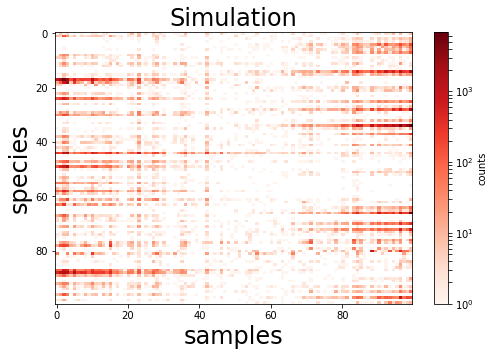

In [5]:
# Plot the heatmap of the counts
fig = plt.figure(figsize=(8, 5))
plt.imshow(table.matrix_data.todense(), 
           aspect='auto', cmap='Reds', 
           norm=colors.LogNorm()
          )
plt.colorbar(label='counts')
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24) 

# Model

This is where we will specify the model.  Specifically

$e_{ij} \sim N(0, \kappa_j)$

$v_{ij} = \gamma_j + g_{i.} \cdot \beta_{.j} + e_{ij}$

$\eta_i = \Psi v_i + \theta_i$

$Y_i \sim Poisson( \exp(\eta_i) )$

$\gamma$ represents the intercept terms and $\beta$ represent the regression coefficient terms.

G and Y are both observed.  Since we are estimating both $B$ and $\theta$, we will need set priors for both of these variables.  We will set unit normal priors on both of these variables

In [6]:
def sparse_matmul(A, B, row_index, col_index):
    """ Sparse matrix multiplication.

    This will try to evaluate the following product

    A[i] @ B[j]

    where i, j are the row and column indices specified in `indices`.

    Parameters
    ----------
    A : tf.Tensor
       Left 2D tensor
    B : tf.Tensor
       Right 2D tensor
    row_idx : tf.Tensor
       Row indexes to access in A
    col_idx : tf.Tensor
       Column indexes to access in B


    Returns
    -------
    tf.Tensor
       Result stored in a sparse tensor format, where the values
       are derived from A[i] @ B[j] where i, j are the row and column
       indices specified in `indices`.
    """
    A_flat = tf.gather(A, row_index, axis=0)
    B_flat = tf.transpose(tf.gather(B, col_index, axis=1))
    values = tf.reduce_sum(tf.multiply(A_flat, B_flat), axis=1)
    return values

def get_batch(M, Y, num_neg=10):
    """ Get's batch data

    Parameters
    ----------
    M : int
        batch size
    Y : scipy.sparse.coo_matrix
        Scipy sparse matrix in COO-format.
    num_neg : int
        Number of negative samples

    Returns
    -------
    pos_row : np.array
        Selected rows for positive values
    pos_col : np.array
        Selected columns for positive values
    pos_data : np.array
        Selected data for positive values
    neg_row : np.array
        Selected rows for negative values
    neg_col : np.array
        Selected columns for negative values
    neg_data : np.array
        Selected data for negative values        
    """
    y_data = Y.data
    y_row = Y.row
    y_col = Y.col
    
    # get positive sample
    positive_idx = np.random.choice(len(y_data), M)
    positive_row = y_row[positive_idx].astype(np.int32)
    positive_col = y_col[positive_idx].astype(np.int32)
    positive_data = y_data[positive_idx].astype(np.float32)

    # store all of the positive (i, j) coords
    idx = np.vstack((y_row, y_col)).T
    idx = set(map(tuple, idx.tolist()))

    # get negative sample
    N, D = Y.shape
    negative_row = np.zeros(num_neg, dtype=np.int32)
    negative_col = np.zeros(num_neg, dtype=np.int32)
    negative_data = np.zeros(num_neg, dtype=np.float32)
    for k in range(num_neg):
        i, j = np.random.randint(N), np.random.randint(D)
        while (i, j) in idx:
            i, j = np.random.randint(N), np.random.randint(D)
        negative_row[k] = i
        negative_col[k] = j
                   
    return (positive_row, positive_col, positive_data, 
            negative_row, negative_col, negative_data)

In [7]:
# Priors
gamma_mean = 0
gamma_scale = 2
beta_mean = 0
beta_scale = 2
learning_rate = 0.1

# Mini batch size
batch_size = 100
num_neg = 10

epoch = table.nnz // batch_size
#num_iter = int(epoch * batch_size)
num_epoch = 5
num_iter = int(epoch * num_epoch)

basis = basis.T

biom_data = table.matrix_data.tocoo().T

config = tf.ConfigProto(intra_op_parallelism_threads=2, 
                        inter_op_parallelism_threads=2,
                        device_count={'CPU': 4}) 
session = tf.InteractiveSession(config=config)

In [8]:
from edward.models import Normal, Poisson

# Place holder variables to accept input data                                                                 
Gpos_ph = tf.placeholder(tf.float32, [batch_size, p], name='G_pos')
Gneg_ph = tf.placeholder(tf.float32, [num_neg, p], name='G_neg')
Y_ph = tf.placeholder(tf.float32, [batch_size], name='Y_ph')
pos_row = tf.placeholder(tf.int32, shape=[batch_size], name='pos_row')
pos_col = tf.placeholder(tf.int32, shape=[batch_size], name='pos_col')
neg_row = tf.placeholder(tf.int32, shape=[num_neg], name='neg_row')
neg_col = tf.placeholder(tf.int32, shape=[num_neg], name='neg_col')

neg_data = tf.zeros(shape=[num_neg], name='neg_data', dtype=tf.float32)
total_zero = tf.constant(table.shape[0] * table.shape[1] - table.nnz, dtype=tf.float32)
total_nonzero = tf.constant(table.nnz, dtype=tf.float32)

# Define PointMass Variables first
qgamma = tf.Variable(tf.random_normal([1, D-1]), name='qgamma')
theta = tf.Variable(tf.random_normal([N, 1]), name='theta')
qbeta = tf.Variable(tf.random_normal([p, D-1]), name='qB')

# Distributions
# sample bias (for overdispersion)
# theta = Normal(loc=tf.zeros([N, 1]) + theta_mean,
#                scale=tf.ones([N, 1]) * theta_scale,
#                name='theta')
# species bias
gamma = Normal(loc=tf.zeros([1, D-1]) + gamma_mean,
               scale=tf.ones([1, D-1]) * gamma_scale, 
               name='gamma')
# regression coefficents distribution
beta = Normal(loc=tf.zeros([p, D-1]) + beta_mean,
              scale=tf.ones([p, D-1]) * beta_scale, 
              name='B')

Bprime = tf.concat([qgamma, qbeta], axis=0)

# add bias terms for samples
Gpos = tf.concat([tf.ones([batch_size, 1]), Gpos_ph], axis=1)
Gneg = tf.concat([tf.ones([num_neg, 1]), Gneg_ph], axis=1)

# Convert basis to SparseTensor
psi = tf.SparseTensor(
    indices=np.mat([basis.row, basis.col]).transpose(),
    values=basis.data,
    dense_shape=basis.shape) 

V = tf.transpose(
    tf.sparse_tensor_dense_matmul(psi, tf.transpose(Bprime))
)

# sparse matrix multiplication for positive samples
pos_prime = tf.reduce_sum(
    tf.multiply(
        Gpos, tf.transpose(
            tf.gather(V, pos_col, axis=1))),
    axis=1)
pos_phi = tf.reshape(tf.gather(theta, pos_row), shape=[batch_size]) + pos_prime
Y = Poisson(log_rate=pos_phi, name='Y') 

# sparse matrix multiplication for negative samples
neg_prime = tf.reduce_sum(
    tf.multiply(
        Gneg, tf.transpose(
            tf.gather(V, neg_col, axis=1))),
    axis=1)
neg_phi = tf.reshape(tf.gather(theta, neg_row), shape=[num_neg]) + neg_prime
neg_poisson = Poisson(log_rate=neg_phi, name='neg_counts')

loss = -(
    tf.reduce_mean(gamma.log_prob(qgamma)) + \
    tf.reduce_mean(beta.log_prob(qbeta)) + \
    tf.reduce_mean(Y.log_prob(Y_ph)) + \
    tf.reduce_mean(neg_poisson.log_prob(neg_data))
)

optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.9)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 10.0)
train = optimizer.apply_gradients(zip(gradients, variables))

tf.summary.scalar('loss', loss)
tf.summary.histogram('theta', theta)
tf.summary.histogram('qbeta', qbeta)
tf.summary.histogram('qgamma', qgamma)
#tf.summary.histogram('gradients', gradients)
merged = tf.summary.merge_all()
tf.global_variables_initializer().run()

writer = tf.summary.FileWriter(save_path, session.graph)
G_data = metadata.values.astype(np.float32)
losses = np.array([0.] * num_iter)
idx = np.arange(metadata.shape[0])
for i in tqdm(range(num_iter)):
    batch_idx = np.random.choice(idx, size=batch_size)
    batch = get_batch(batch_size, biom_data, num_neg=num_neg)
    (positive_row, positive_col, positive_data,
     negative_row, negative_col, negative_data) = batch
    feed_dict={
            Y_ph: positive_data, 
            Gpos_ph: G_data[positive_row, :],
            Gneg_ph: G_data[negative_row, :],
            pos_row: positive_row,
            pos_col: positive_col,
            neg_row: negative_row,
            neg_col: negative_col
    }    
    _, summary, train_loss, grads = session.run(
        [train, merged, loss, gradients], 
        feed_dict=feed_dict
    )
    writer.add_summary(summary, i)
    losses[i] = train_loss
    #print("Step %d / %d: lr = %5.2f loss = %6.2f\r" %
    #      (i, num_iter, lr, train_loss))

100%|██████████| 190/190 [00:01<00:00, 168.88it/s]


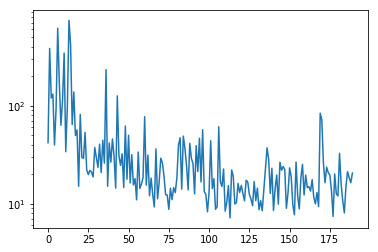

In [9]:
plt.plot(losses)
plt.yscale('log')

In [10]:
beta_ = qbeta.eval()
gamma_ = qgamma.eval()
theta_ = theta.eval()

(0.9277332273912502, 2.646097292508442e-43)


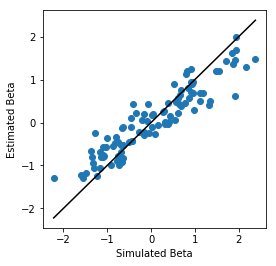

In [11]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(figsize=(4, 4))
x = np.ravel(sim_beta)
y = np.ravel(beta_)
ax.scatter(x, y)
mx = np.linspace(min([sim_beta.values.min(), beta_.min()]), 
                 max([sim_beta.values.max(), beta_.max()]))
ax.plot(mx, mx, '-k')
plt.xlabel('Simulated Beta')
plt.ylabel('Estimated Beta')
print(pearsonr(x, y))

(0.6609538398063893, 9.697805899876175e-14)


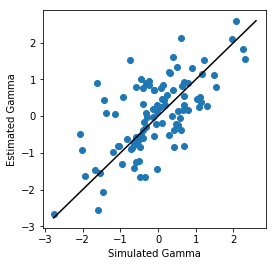

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
x = np.ravel(sim_gamma)
y = np.ravel(gamma_)
ax.scatter(x, y)
mx = np.linspace(min([sim_gamma.values.min(), gamma_.min()]), 
                 max([sim_gamma.values.max(), gamma_.max()]))
ax.plot(mx, mx, '-k')
plt.xlabel('Simulated Gamma')
plt.ylabel('Estimated Gamma')
print(pearsonr(x, y))

(0.936126758884532, 2.842222323927871e-46)


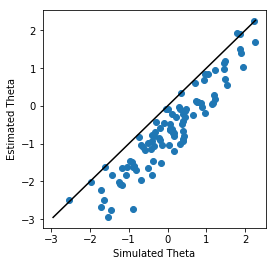

In [13]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(figsize=(4, 4))
x = np.ravel(sim_theta)
y = np.ravel(theta_)
ax.scatter(x, y)
mx = np.linspace(min([sim_theta.values.min(), theta_.min()]), 
                 max([sim_theta.values.max(), theta_.max()]))
ax.plot(mx, mx, '-k')
plt.xlabel('Simulated Theta')
plt.ylabel('Estimated Theta') 
print(pearsonr(x, y))

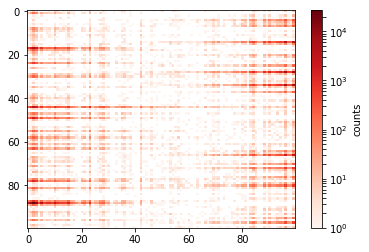

In [14]:
plt.imshow(np.random.poisson(
    np.exp(theta_ + (G_data @ beta_ + gamma_) @ basis.T).T), 
           aspect='auto', cmap='Reds', 
           norm=colors.LogNorm()
          ) 
plt.colorbar(label='counts')

Text(0.5,1,'Simulation')

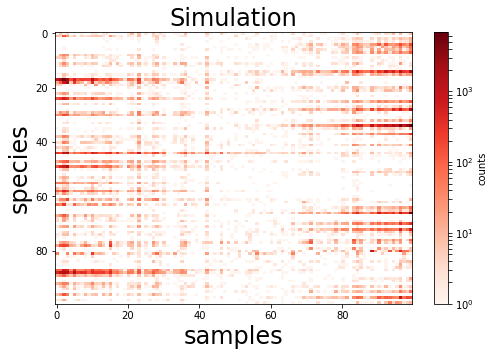

In [15]:
# Plot the heatmap of the counts
fig = plt.figure(figsize=(8, 5))
plt.imshow(table.matrix_data.todense(), 
           aspect='auto', cmap='Reds', 
           norm=colors.LogNorm()
          )
plt.colorbar(label='counts') 
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24) 

In [16]:
pred = np.exp(theta_ + (G_data @ beta_ + gamma_) @ basis.T)
obs = table.matrix_data.todense()

In [17]:
obs.sum(axis=1).min()

10.0